<a href="https://colab.research.google.com/github/WeronikaRedlinska/ForexForecast/blob/main/HalfHourly_LSTM_ARIMA_WR_longer_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
%cd /content/drive/MyDrive/Magisterka2025/LSTM/data

/content/drive/MyDrive/Magisterka2025/LSTM/data


In [245]:
!pip install darts

In [246]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

#importing data

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import os

In [247]:
import yfinance as yf
import pandas as pd

ticker = 'EURUSD=X'
start_date = '2025-04-01'
end_date = '2025-05-20'

data = yf.download(
    tickers=ticker,
    interval='30m',
    start=start_date,
    end=end_date,
    progress=False
)

if data.empty:
    print("No data retrieved.")
else:
    data.to_csv('EURUSD_halfhourly_march2025.csv')
    print("Data saved to EURUSD_halfhourly_march2025.csv")
    print(data.head())


Data saved to EURUSD_halfhourly_march2025.csv
Price                         Close      High       Low      Open   Volume
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Datetime                                                                  
2025-03-31 23:00:00+00:00  1.081900  1.082251  1.081783  1.082134        0
2025-03-31 23:30:00+00:00  1.082017  1.082134  1.081783  1.081900        0
2025-04-01 00:00:00+00:00  1.082485  1.082837  1.082134  1.082134        0
2025-04-01 00:30:00+00:00  1.082837  1.082954  1.082368  1.082485        0
2025-04-01 01:00:00+00:00  1.082720  1.082954  1.082485  1.082720        0


# LSTM alone


In [248]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka2025/LSTM/data/EURUSD_halfhourly_march2025.csv")
df = df.drop([0,1])
df = df.rename(columns={'Price':'Date'})
headers = ['Close','High','Low','Open']
for header in headers:
  df[header]=df[header].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace= True)


df['prev_close'] = df['Close'].shift(1)
df['Return']=(df['Close']/df['prev_close'] - 1)*100
df = df.iloc[1:]
df = df.loc[:, [ 'Return', 'Close', 'High', 'Low', 'Open', 'Volume', 'prev_close']]
df.head()

,Return,Close,High,Low,Open,Volume,prev_close
Date,,,,,,,
2025-03-31 23:30:00+00:00,0.010820,1.082017,1.082134,1.081783,1.081900,0,1.081900
2025-04-01 00:00:00+00:00,0.043309,1.082485,1.082837,1.082134,1.082134,0,1.082017
2025-04-01 00:30:00+00:00,0.032476,1.082837,1.082954,1.082368,1.082485,0,1.082485
2025-04-01 01:00:00+00:00,-0.010822,1.082720,1.082954,1.082485,1.082720,0,1.082837
2025-04-01 01:30:00+00:00,-0.032469,1.082368,1.082603,1.082017,1.082603,0,1.082720


In [249]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30min')
df = df.reindex(full_range)
df = df.fillna(method='ffill')
df.head()


<ipython-input-249-e34410ccf8af>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Return,Close,High,Low,Open,Volume,prev_close
2025-03-31 23:30:00+00:00,0.010820,1.082017,1.082134,1.081783,1.081900,0,1.081900
2025-04-01 00:00:00+00:00,0.043309,1.082485,1.082837,1.082134,1.082134,0,1.082017
2025-04-01 00:30:00+00:00,0.032476,1.082837,1.082954,1.082368,1.082485,0,1.082485
2025-04-01 01:00:00+00:00,-0.010822,1.082720,1.082954,1.082485,1.082720,0,1.082837
2025-04-01 01:30:00+00:00,-0.032469,1.082368,1.082603,1.082017,1.082603,0,1.082720


In [250]:
series = TimeSeries.from_dataframe(df, value_cols='Return', freq='30min' )
train_size = int(0.8 * len(series))
train, val = series[:train_size], series[train_size:]

<Axes: xlabel='time'>

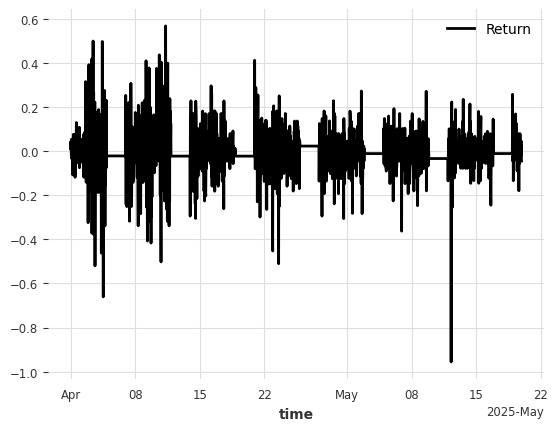

In [251]:
series.plot()

<Axes: xlabel='time'>

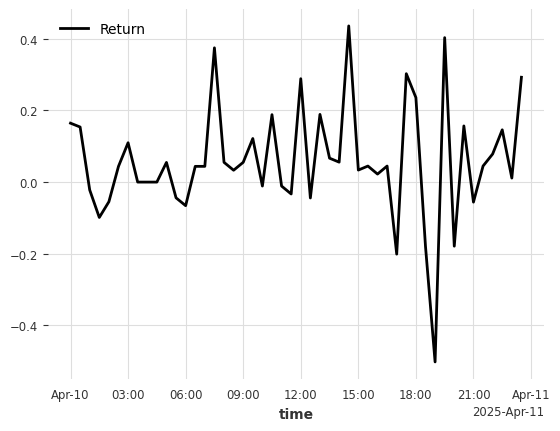

In [252]:
one_day_df = df.loc['2025-04-10']
one_day_df
series_one_day = TimeSeries.from_dataframe(one_day_df, value_cols='Return', freq='30min')
series_one_day.plot()

In [253]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [254]:
time_index = pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0])

month_series = datetime_attribute_timeseries(
                  time_index,
                  attribute = "month",
                  one_hot = True)

weekday_series = datetime_attribute_timeseries(time_index,
                                           attribute = "weekday",
                                            one_hot = True)

#cyclical covariates for hour
hour = time_index.hour
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)

hour_df = pd.DataFrame({'hour_sin': hour_sin, 'hour_cos': hour_cos}, index=time_index)
hour_series = TimeSeries.from_dataframe(hour_df)

#cyclical covariates for half an hour
minute = time_index.minute
half_hour_fraction = minute / 60
half_hour_sin = np.sin(2 * np.pi * half_hour_fraction)
half_hour_cos = np.cos(2 * np.pi * half_hour_fraction)
half_hour_df = pd.DataFrame({'half_hour_sin': half_hour_sin, 'half_hour_cos': half_hour_cos}, index=time_index)
half_hour_series = TimeSeries.from_dataframe(half_hour_df)

covariates = month_series.stack(weekday_series).stack(hour_series).stack(half_hour_series)

In [255]:
covariates

<TimeSeries (DataArray) (time: 2351, component: 23, sample: 1)> Size: 433kB
array([[[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 1.00000000e+00],
        ...,
        [ 9.65925826e-01],
        [ 1.22464680e-16],
        [-1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 1.00000000e+00],
        [ 0.00000000e+00],
        [ 1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
...
        ...,
        [ 7.07106781e-01],
        [ 1.22464680e-16],
        [-1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 8.66025404e-01],
        [ 0.00000000e+00],
        [ 1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 8.66025404e-01],
        [ 1.22464680e-16],
        [-1.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 19kB 2025-03-31T23:30:00 ... 2025-05-19T...
  * component  (component) object 184B 'month_0' 'month_1' ... 'half_hour_cos'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [256]:
covariates_size = int(0.8 * len(covariates))
cov_train, cov_val = covariates[:covariates_size], covariates[covariates_size:]

In [257]:
model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.2,
    n_rnn_layers =1,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 0.002},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=55,
    input_chunk_length=50,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                  "devices": [0]}
)

In [258]:
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.2, training_length=55, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 0.002}, model_name=Forex_LSTM, log_tensorboard=True, random_state=42, input_chunk_length=50, force_reset=True, save_checkpoints=True)

In [259]:
pred_series = model.predict(len(val), future_covariates=covariates)
pred_series

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (time: 471, component: 1, sample: 1)> Size: 4kB
array([[[0.52926404]],

       [[0.51786323]],

       [[0.52233339]],

       [[0.52181881]],

       [[0.52013526]],

       [[0.52269316]],

       [[0.52174133]],

       [[0.52113486]],

       [[0.52676512]],

       [[0.52169251]],

...

       [[0.56005621]],

       [[0.52963143]],

       [[0.56600783]],

       [[0.53707242]],

       [[0.55197742]],

       [[0.53563212]],

       [[0.53133894]],

       [[0.53641612]],

       [[0.51477714]],

       [[0.54074932]]])
Coordinates:
  * time       (time) datetime64[ns] 4kB 2025-05-10T03:30:00 ... 2025-05-19T2...
  * component  (component) object 8B 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='time'>

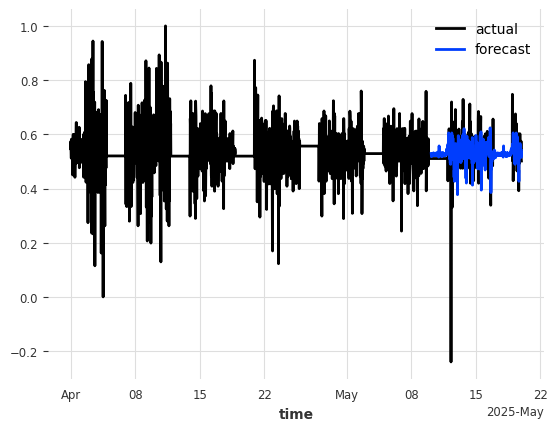

In [260]:
series_transformed.plot(label="actual")
pred_series.plot(label="forecast")

<Axes: xlabel='time'>

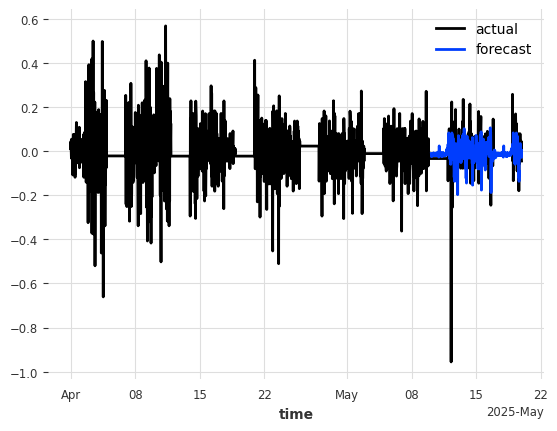

In [261]:
# transformer = Scaler()
# series_transformed = transformer.fit_transform(series)
predictions = transformer.inverse_transform(pred_series)
series.plot(label='actual')
predictions.plot(label='forecast')

In [262]:
start_date = predictions.start_time()
end_date = predictions.end_time()
series_actual = series.slice(start_date, end_date)
actual_values = series_actual.values().flatten()
predicted_values = predictions.values().flatten()
rmse_lstm_alone = np.sqrt(mean_squared_error(actual_values, predicted_values))
rmse_lstm_alone

np.float64(0.08114086529931629)

<Axes: xlabel='time'>

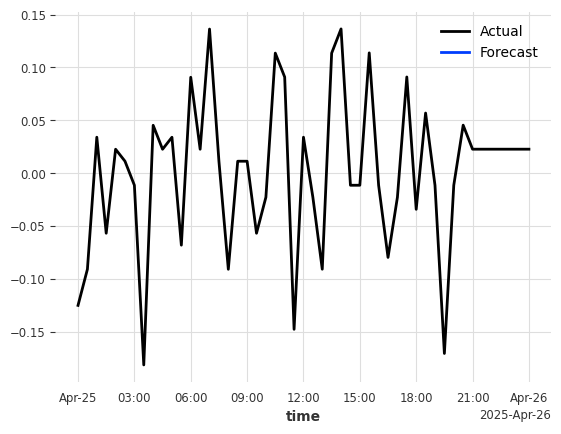

In [263]:
start_day = pd.Timestamp('2025-04-25')
end_day = pd.Timestamp('2025-04-26')
series_day = series.slice(start_day, end_day)
predictions_day = predictions.slice(start_day, end_day)
series_day.plot(label='Actual')
predictions_day.plot(label='Forecast')

# LSTM on seasonal and residual data

In [264]:
import statsmodels.api as sm
df = df.asfreq('30T')
res = sm.tsa.seasonal_decompose(df.Return, model="additive", period=48)
df1 = res.seasonal
df2 = res.resid
df3 = res.trend
df1 = df1.to_frame()
df2 = df2.to_frame()
df3 = df3.to_frame()
df1 = df1.fillna(method='ffill')
df2 = df2.fillna(method='ffill')
df2 = df2.dropna()
df3 = df3.fillna(method='ffill')
df1 = df1.rename(columns={'seasonal':'Return'})
df2 = df2.rename(columns={'resid':'Return'})
df3 = df3.rename(columns={'trend':'Return'})
df = df1
df.head()

series1 = TimeSeries.from_dataframe(df1, value_cols='Return', freq='30T' )
series2 = TimeSeries.from_dataframe(df2, value_cols='Return', freq='30T' )
series3 = TimeSeries.from_dataframe(df3, value_cols='Return', freq='30T' )


<ipython-input-264-dddb45633b74>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('30T')
<ipython-input-264-dddb45633b74>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1 = df1.fillna(method='ffill')
<ipython-input-264-dddb45633b74>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2 = df2.fillna(method='ffill')
<ipython-input-264-dddb45633b74>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df3 = df3.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/darts/timeseries.py:5248: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfr

<Axes: xlabel='time'>

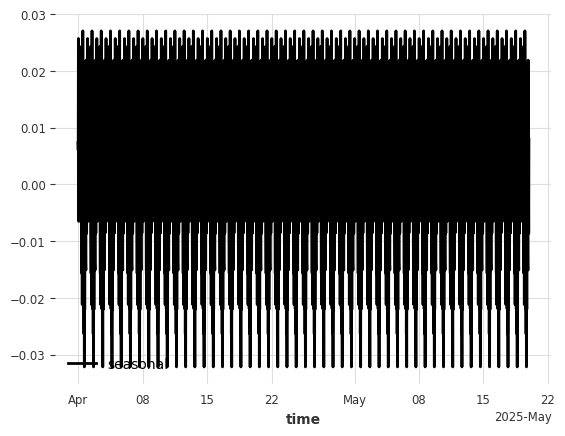

In [265]:
series1.plot(label="seasonal")


<Axes: xlabel='time'>

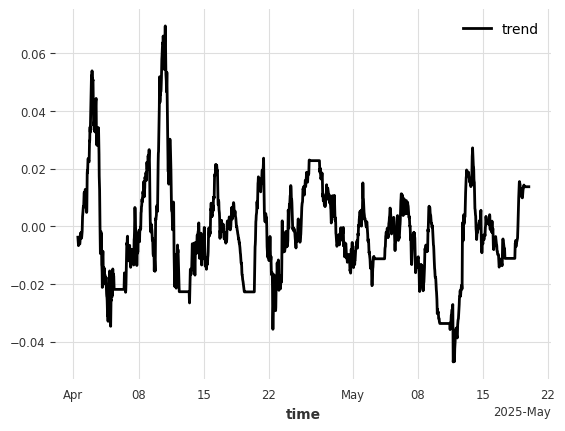

In [266]:
series3.plot(label="trend")

<Axes: xlabel='time'>

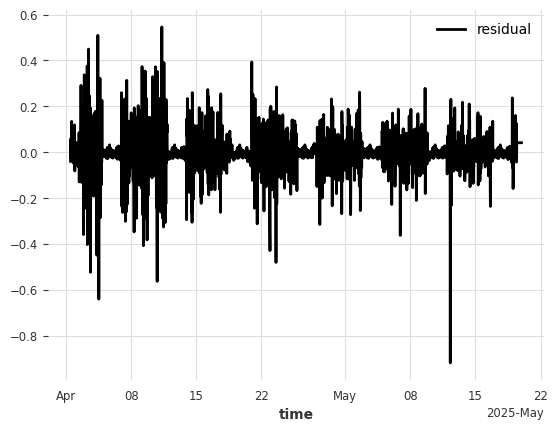

In [267]:
series2.plot(label="residual")


In [268]:
val_size = int(0.2 * len(series))
val_size

470

In [269]:
#Seasonal data training setup
train_size = int(0.8 * len(series1))
train, val = series1[:train_size], series1[train_size:]

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series1)

In [270]:
model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.2,
    n_rnn_layers =1,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 0.002},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=55,
    input_chunk_length=50,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                  "devices": [0]}
)

In [271]:
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.2, training_length=55, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 0.002}, model_name=Forex_LSTM, log_tensorboard=True, random_state=42, input_chunk_length=50, force_reset=True, save_checkpoints=True)

In [272]:
pred_series = model.predict(val_size, future_covariates=covariates)

predictions_seasonal = transformer.inverse_transform(pred_series)

start_date = predictions_seasonal.start_time()
end_date = predictions_seasonal.end_time()
series_actual = series.slice(start_date, end_date)

actual_values = series_actual.values().flatten() # Use .values().flatten() to get a 1D numpy array
predicted_values = predictions_seasonal.values().flatten()

error = np.sqrt(mean_squared_error(actual_values, predicted_values))
error

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

np.float64(0.07290786176612574)

<Axes: xlabel='time'>

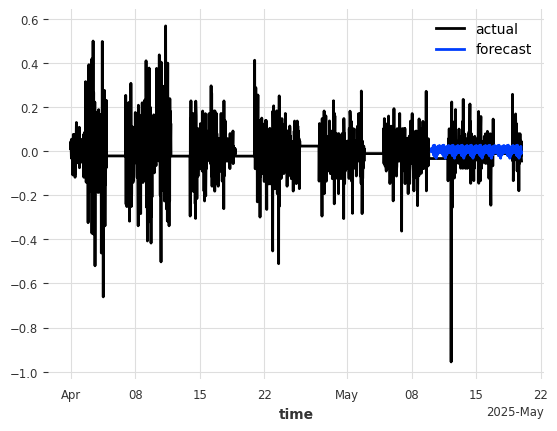

In [273]:
series.plot(label="actual")
predictions_seasonal.plot(label="forecast")

<Axes: xlabel='time'>

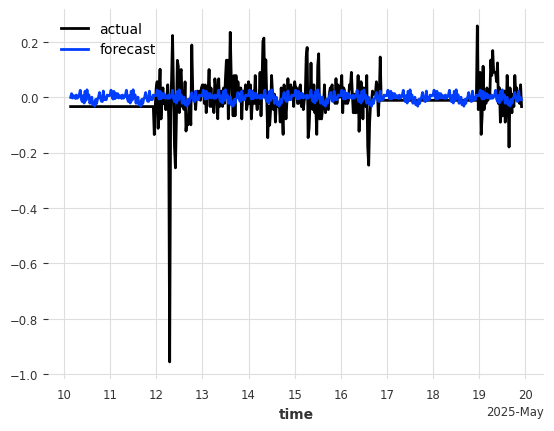

In [274]:
series_actual.plot(label="actual")
predictions_seasonal.plot(label="forecast")

<Axes: xlabel='time'>

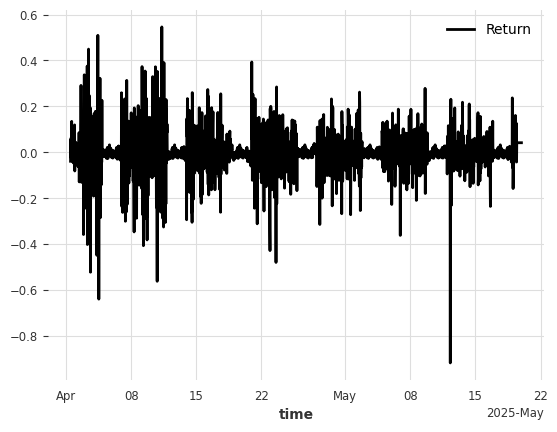

In [275]:
series2.plot()

In [276]:
#Residual data training setup
train_size = int(0.8 * len(series2))
train, val = series2[:train_size], series2[train_size:]

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series2)

time_index = pd.date_range(start = series2.start_time(),
                  freq = series2.freq_str,
                  periods = df.shape[0])

month_series = datetime_attribute_timeseries(
                  time_index,
                  attribute = "month",
                  one_hot = True)

weekday_series = datetime_attribute_timeseries(time_index,
                                           attribute = "weekday",
                                            one_hot = True)

#cyclical covariates for hour
hour = time_index.hour
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)

hour_df = pd.DataFrame({'hour_sin': hour_sin, 'hour_cos': hour_cos}, index=time_index)
hour_series = TimeSeries.from_dataframe(hour_df)

#cyclical covariates for half an hour
minute = time_index.minute
half_hour_fraction = minute / 60
half_hour_sin = np.sin(2 * np.pi * half_hour_fraction)
half_hour_cos = np.cos(2 * np.pi * half_hour_fraction)
half_hour_df = pd.DataFrame({'half_hour_sin': half_hour_sin, 'half_hour_cos': half_hour_cos}, index=time_index)
half_hour_series = TimeSeries.from_dataframe(half_hour_df)

covariates = month_series.stack(weekday_series).stack(hour_series).stack(half_hour_series)



In [277]:
model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.2,
    n_rnn_layers =1,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 0.002},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=55,
    input_chunk_length=50,
    output_chunk_length=5,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                  "devices": [0]}
)

In [278]:
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.2, training_length=55, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 0.002}, model_name=Forex_LSTM, log_tensorboard=True, random_state=42, input_chunk_length=50, output_chunk_length=5, force_reset=True, save_checkpoints=True)

In [279]:

pred_series = model.predict(val_size, future_covariates=covariates)

# transformer = Scaler()
# series_transformed = transformer.fit_transform(series2)
predictions_residual = transformer.inverse_transform(pred_series)

start_date = pred_series.start_time()
end_date = pred_series.end_time()
series_actual = series.slice(start_date, end_date)


actual_values = series_actual.values().flatten()
predicted_values = pred_series.values().flatten()

min_len = min(len(actual_values), len(predicted_values))
error = np.sqrt(mean_squared_error(actual_values[:min_len], predicted_values[:min_len]))

error

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

np.float64(0.5600394003130784)

In [280]:
series_actual_trimmed = series_actual[:min_len]
predictions_residual_trimmed = predictions_residual[:min_len]

# Print the corresponding time indexes
print("Time indexes of actual_values[:min_len]:")
print(series_actual_trimmed.time_index)

print("\nTime indexes of predicted_values[:min_len]:")
print(predictions_residual_trimmed.time_index)

Time indexes of actual_values[:min_len]:
DatetimeIndex(['2025-05-10 06:00:00', '2025-05-10 06:30:00',
               '2025-05-10 07:00:00', '2025-05-10 07:30:00',
               '2025-05-10 08:00:00', '2025-05-10 08:30:00',
               '2025-05-10 09:00:00', '2025-05-10 09:30:00',
               '2025-05-10 10:00:00', '2025-05-10 10:30:00',
               ...
               '2025-05-19 18:00:00', '2025-05-19 18:30:00',
               '2025-05-19 19:00:00', '2025-05-19 19:30:00',
               '2025-05-19 20:00:00', '2025-05-19 20:30:00',
               '2025-05-19 21:00:00', '2025-05-19 21:30:00',
               '2025-05-19 22:00:00', '2025-05-19 22:30:00'],
              dtype='datetime64[ns]', name='time', length=466, freq='30min')

Time indexes of predicted_values[:min_len]:
DatetimeIndex(['2025-05-10 06:00:00', '2025-05-10 06:30:00',
               '2025-05-10 07:00:00', '2025-05-10 07:30:00',
               '2025-05-10 08:00:00', '2025-05-10 08:30:00',
               '2025-05-

<Axes: xlabel='time'>

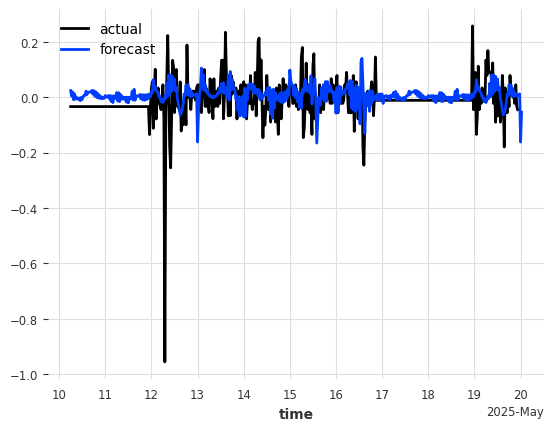

In [281]:
series_actual.plot(label="actual")
predictions_residual.plot(label="forecast")

In [282]:
prediction_seasonal_residual = predictions_seasonal + predictions_residual

In [283]:
prediction = prediction_seasonal_residual.values().flatten()
min_len = min(len(actual_values), len(prediction))
error = np.sqrt(mean_squared_error(actual_values[:min_len], prediction[:min_len]))
error

np.float64(0.08131995860355998)

<Axes: xlabel='time'>

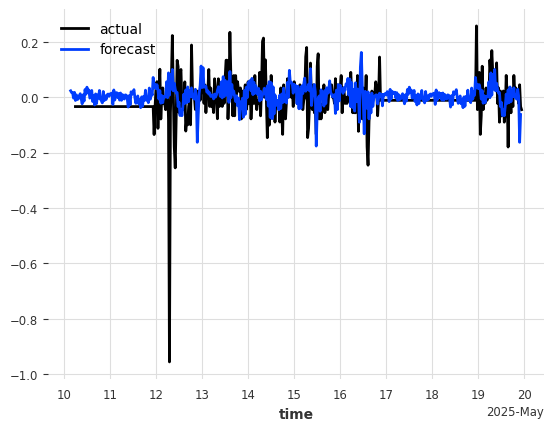

In [284]:
series_actual.plot(label="actual")
prediction_seasonal_residual.plot(label="forecast")

# ARIMA on trend data


In [285]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [286]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka2025/LSTM/data/EURUSD_halfhourly_march2025.csv")
df = df.drop([0,1])
df = df.rename(columns={'Price':'Date'})
headers = ['Close','High','Low','Open']
for header in headers:
  df[header]=df[header].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace= True)


df['prev_close'] = df['Close'].shift(1)
df['Return']=(df['Close']/df['prev_close'] - 1)*100
df = df.iloc[1:]
df = df.loc[:, [ 'Return', 'Close', 'High', 'Low', 'Open', 'Volume', 'prev_close']]
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30T')
df = df.reindex(full_range)
df = df.fillna(method='ffill')
df.head()


<ipython-input-286-f1d6f86c3944>:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30T')
<ipython-input-286-f1d6f86c3944>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Return,Close,High,Low,Open,Volume,prev_close
2025-03-31 23:30:00+00:00,0.010820,1.082017,1.082134,1.081783,1.081900,0,1.081900
2025-04-01 00:00:00+00:00,0.043309,1.082485,1.082837,1.082134,1.082134,0,1.082017
2025-04-01 00:30:00+00:00,0.032476,1.082837,1.082954,1.082368,1.082485,0,1.082485
2025-04-01 01:00:00+00:00,-0.010822,1.082720,1.082954,1.082485,1.082720,0,1.082837
2025-04-01 01:30:00+00:00,-0.032469,1.082368,1.082603,1.082017,1.082603,0,1.082720


In [287]:
df = df.asfreq('30T')
res = sm.tsa.seasonal_decompose(df.Return, model="additive", period=48)
df = res.trend
df = df.to_frame()
df = df.fillna(0)
df = df.rename(columns={'trend':'Return'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2351 entries, 2025-03-31 23:30:00+00:00 to 2025-05-19 22:30:00+00:00
Freq: 30min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Return  2351 non-null   float64
dtypes: float64(1)
memory usage: 36.7 KB


<ipython-input-287-f5d4aa7cc7c7>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('30T')


In [288]:
df = pd.DataFrame(df, columns=['Return'])
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [289]:
from statsmodels.tsa.stattools import adfuller
import itertools

result = adfuller(train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")



ADF Statistic: -5.174224340841982
p-value: 9.9223233511362e-06


In [290]:
train_series = train.squeeze()
train_series = train.squeeze()
print(type(train_series), train_series.shape)
train_series = train_series.replace([np.inf, -np.inf], np.nan).dropna()

p = range(0, 4)
d = range(0, 2)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

for param in pdq:
    try:
        model = sm.tsa.arima.ARIMA(train_series, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_model = results
    except Exception as e:
        print(f"ARIMA{param} failed: {type(e).__name__}: {e}")

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

<class 'pandas.core.series.Series'> (1880,)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWar

Best ARIMA order: (1, 0, 3) with AIC: -19119.6726529914


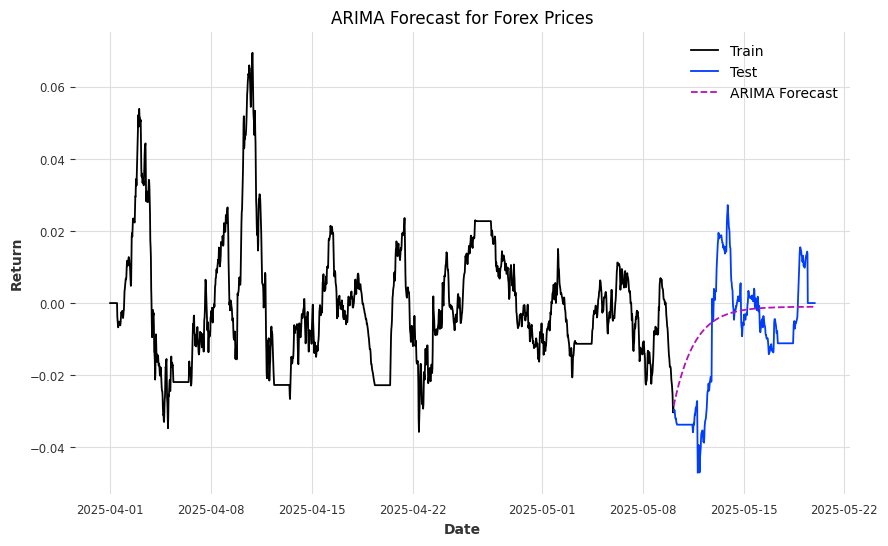

In [291]:

arima_model = sm.tsa.arima.ARIMA(train, order=(1, 0, 3))
arima_fitted = arima_model.fit()

arima_forecast = arima_fitted.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()



In [292]:
from sklearn.metrics import mean_squared_error
import math

In [293]:
arima_rmse = math.sqrt(mean_squared_error(test['Return'], arima_forecast))
print(f"ARIMA RMSE: {arima_rmse:.4f}")

ARIMA RMSE: 0.0141


# ARIMA and LSTM together

In [294]:
min_len = min(len(arima_forecast), len(prediction_seasonal_residual))
prediction_seasonal_residual = prediction_seasonal_residual.values().flatten()
full_forecast = arima_forecast[:min_len] + prediction_seasonal_residual[:min_len]


In [295]:
full_forecast.head()

,predicted_mean
2025-05-10 03:30:00+00:00,-0.005339
2025-05-10 04:00:00+00:00,-0.011185
2025-05-10 04:30:00+00:00,-0.010871
2025-05-10 05:00:00+00:00,-0.030509
2025-05-10 05:30:00+00:00,-0.009333


/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


<Axes: xlabel='time'>

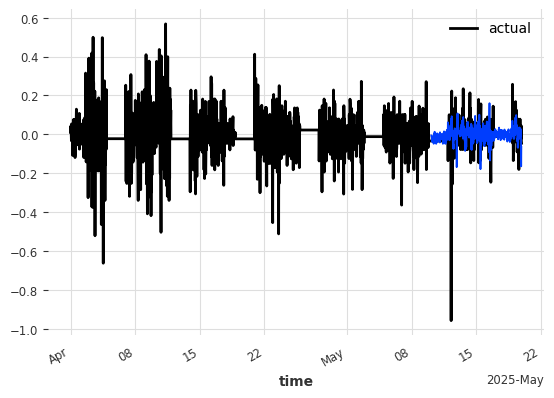

In [296]:
series.plot(label="actual")
full_forecast.plot(label="forecast")

In [297]:
start_date = predictions.start_time()
end_date = predictions.end_time()
series_actual = series.slice(start_date, end_date)
actual_values = series_actual.values().flatten()
final_rmse = math.sqrt(mean_squared_error(actual_values[:min_len], full_forecast))
final_rmse

0.07765815538666494

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


<Axes: xlabel='time'>

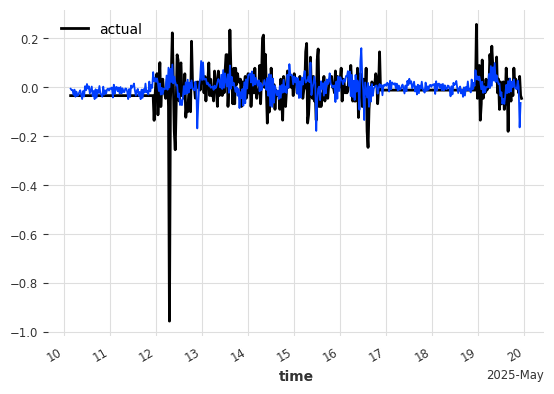

In [298]:
series_actual.plot(label="actual")
full_forecast.plot(label="forecast")